In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the organized dataset
organized_data_dir = './data/pets/formatted_images'
dataset = datasets.ImageFolder(root=organized_data_dir, transform=transform)
dataset_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Loaded {len(dataset)} images under {len(dataset.classes)} classes.")


Loaded 7390 images under 35 classes.


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Aqui se puede ver como se intento realizar una implementacion custom de resnet, con transformaciones para intentar evitar el sobrenetreno
desde rotaciones, color jitter, y flips horizontales, y con un dropout dentro del modelo incluido.
Se incluyo un early stopping tambien para evitar que como en el primer modelo, bajase la validation accuracy debido a sobreentreno

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
from torch import nn, optim

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data augmentation for training and normalization for validation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
data_dir = './data/pets/formatted_images'
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

# Splitting datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the model with BatchNorm and Dropout
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

model = CustomResNet(len(train_dataset.dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


num_epochs = 10
best_val_accuracy = 0
epochs_no_improve = 0
n_epochs_stop = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy after epoch {epoch+1}: {val_accuracy}%')

    # Check early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping!")
            break

print("Finished Training")


C:\Users\usuario\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.3261710108937446
Validation Accuracy after epoch 1: 28.552097428958053%
Epoch 2, Loss: 1.7724812034014108
Validation Accuracy after epoch 2: 47.699594046008116%
Epoch 3, Loss: 1.525680046790355
Validation Accuracy after epoch 3: 56.630581867388365%
Epoch 4, Loss: 1.3706472219647587
Validation Accuracy after epoch 4: 55.00676589986468%
Epoch 5, Loss: 1.3348229504920341
Validation Accuracy after epoch 5: 61.36671177266577%
Epoch 6, Loss: 1.2519757493122203
Validation Accuracy after epoch 6: 62.44925575101489%
Epoch 7, Loss: 1.139319961457639
Validation Accuracy after epoch 7: 61.231393775372126%
Epoch 8, Loss: 1.1680936639373367
Validation Accuracy after epoch 8: 59.20162381596752%
Epoch 9, Loss: 1.120691933503022
Validation Accuracy after epoch 9: 61.56968876860623%
Early stopping!
Finished Training


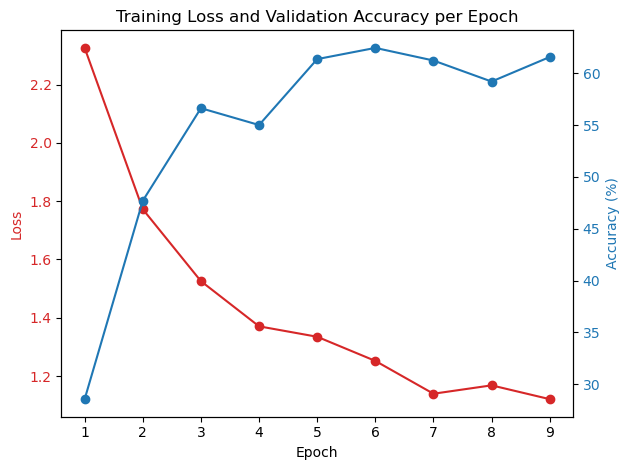

In [1]:
import matplotlib.pyplot as plt

epochs = list(range(1, 10))  # 9 epochs debido al early stop

losses = [
    2.3261710108937446, 1.7724812034014108, 1.525680046790355,
    1.3706472219647587, 1.3348229504920341, 1.2519757493122203,
    1.139319961457639, 1.1680936639373367, 1.120691933503022
]

accuracies = [
    28.552097428958053, 47.699594046008116, 56.630581867388365,
    55.00676589986468, 61.36671177266577, 62.44925575101489,
    61.231393775372126, 59.20162381596752, 61.56968876860623
]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, losses, color=color, marker='o', label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epochs, accuracies, color=color, marker='o', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss and Validation Accuracy per Epoch')
fig.tight_layout()

plt.show()


Un plot bastante habitual, si no fuese por los resultados decepcionantes, el cambio a custom no mejoro en absoluto nada excepto el sobre-entreno

In [2]:
correct = 0
total = 0
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'training Accuracy after epoch {epoch+1}: {100 * correct / total}%')

Validation Accuracy after epoch 9: 68.2171853856563%


El de arriba es training abajo validation

In [3]:
correct = 0
total = 0
for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Validation Accuracy after epoch {epoch+1}: {100 * correct / total}%')

Validation Accuracy after epoch 9: 61.97564276048715%


Este modelo no sobreentrena de manera tan enorme, pero simplemente no es bueno en cuanto a resultados, por lo que se decidio
abandonar por completo el resnet18. Aunque se podrian haber tenido resultados mejorados con algunos retoques, como quitar el color jitter
se decidio que el entrenamiento era demasiado lento.